## Q.81. Hessianのコーナー検出

*thorino.jpg*にHessian(ヘシアン)のコーナー検出を行え。

コーナー検出とはエッジにおける角の点を検出することである。

コーナーは曲率が大きくなる点であり、次式のガウス曲率において、

```bash
ガウス曲率 K = det(H) / (1 + Ix^2 + Iy^2)^2

det(H) = Ixx Iyy - IxIy^2
H ... ヘシアン行列。画像の二次微分(グレースケール画像などに対して、Sobelフィルタを掛けて求められる)。画像上の一点に対して、次式で定義される。
Ix ... x方向のsobelフィルタを掛けたもの。 
Iy ... y方向のsobelフィルタを掛けたもの。
H = [ Ix^2  IxIy]
      IxIy  Iy^2
```

ヘシアンのコーナー検出では、det(H)が極大点をコーナーとみなす。
極大点は注目画素と8近傍を比較して、注目画素の値が最大であれば極大点として扱う。

解答ではdet(H)が極大点かつ、max(det(H))*0.1を超過する点をコーナーとしている。

|入力 (thorino.jpg) |出力(answers/answer_81.jpg)|
|:---:|:---:|
|![](thorino.jpg)|![](answers/answer_81.jpg)|

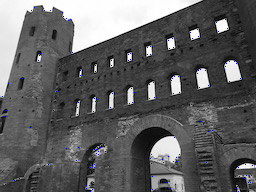

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Read image
img = cv2.imread("thorino.jpg").astype(np.float32)
H, W, C = img.shape

## Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
gray = gray.astype(np.uint8)

## Sobel
sobely = np.array(((1, 2, 1),
                   (0, 0, 0),
                   (-1, -2, -1)), dtype=np.float32)

sobelx = np.array(((1, 0, -1),
                   (2, 0, -2),
                   (1, 0, -1)), dtype=np.float32)

tmp = np.pad(gray, (1, 1), 'edge')

Ix = np.zeros_like(gray, dtype=np.float32)
Iy = np.zeros_like(gray, dtype=np.float32)

for y in range(H):
    for x in range(W):
        Ix[y, x] = np.mean(tmp[y:y+3, x:x+3] * sobelx)
        Iy[y, x] = np.mean(tmp[y:y+3, x:x+3] * sobely)

tmp = np.pad(Ix, (1, 1), 'edge')

Ix2 = np.zeros_like(gray, dtype=np.float32)
IxIy = np.zeros_like(gray, dtype=np.float32)

for y in range(H):
    for x in range(W):
        Ix2[y, x] = np.mean(tmp[y:y+3, x:x+3] * sobelx)
        IxIy[y, x] = np.mean(tmp[y:y+3, x:x+3] * sobely)

tmp = np.pad(Iy, (1, 1), 'edge')

Iy2 = np.zeros_like(gray, dtype=np.float32)

for y in range(H):
    for x in range(W):
        Iy2[y, x] = np.mean(tmp[y:y+3, x:x+3] * sobely)

out = np.array((gray, gray, gray))
out = np.transpose(out, (1,2,0))

## Hessian
Hes = np.zeros((H, W))

for y in range(H):
    for x in range(W):
        Hes[y,x] = Ix2[y,x] * Iy2[y,x] - IxIy[y,x] ** 2

## Detect Corner
for y in range(H):
    for x in range(W):
        if Hes[y,x] == np.max(Hes[max(y-1,0):min(y+2,H), max(x-1,0):min(x+2,W)]) and Hes[y,x] > np.max(Hes)*0.1:
            out[y, x] = [0, 0, 255]

out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.82. Harrisのコーナー検出 (Step.1) Sobel + Gauusian

ここからQ.83まで*thorino.jpg*にHarris(ハリス)のコーナー検出を行っていく。

Harrisのコーナー検出のアルゴリズムは、
1. 画像をグレースケール化。
2. Sobelフィルタにより、ヘシアン行列を求める。
```bash
H = [ Ix^2  IxIy]
      IxIy  Iy^2
```
3. Ix^2, Iy^2, IxIyにそれぞれガウシアンフィルターをかける。
4. 各ピクセル毎に、R = det(H) - k (trace(H))^2 を計算する。 (kは実験的に0.04 - 0.16らへんが良いとされる)
5. R >= max(R) * th を満たすピクセルがコーナーとなる。  (thは0.1となることが多い)

Q.82-83においての各パラメータは以下の通り。
- ガウシアンフィルター(k=3, sigma=3)
- k = 0.04, th = 0.1

ここでは1-3までを実装せよ。

|入力 (thorino.jpg) |出力(answers/answer_82.png)|
|:---:|:---:|
|![](thorino.jpg)|![](answers/answer_82.png)|

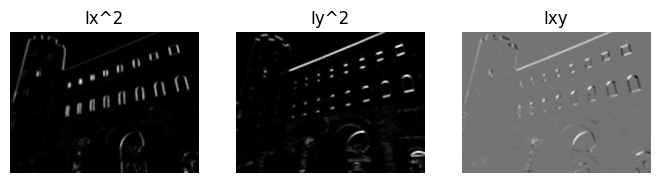

In [2]:
# Read image
img = cv2.imread("thorino.jpg").astype(np.float32)
H, W, C = img.shape

## Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Harris

## Sobel
sobely = np.array(((1, 2, 1),
                   (0, 0, 0),
                   (-1, -2, -1)), dtype=np.float32)

sobelx = np.array(((1, 0, -1),
                   (2, 0, -2),
                   (1, 0, -1)), dtype=np.float32)

tmp = np.pad(gray, (1, 1), 'edge')

Ix = np.zeros_like(gray, dtype=np.float32)
Iy = np.zeros_like(gray, dtype=np.float32)

for y in range(H):
    for x in range(W):
        Ix[y, x] = np.sum(tmp[y:y+3, x:x+3] * sobelx)
        Iy[y, x] = np.sum(tmp[y:y+3, x:x+3] * sobely)

Ix2 = Ix ** 2
Iy2 = Iy ** 2
Ixy = Ix * Iy

## gaussian
K_size = 3
sigma = 3
Ix2_t = np.pad(Ix2, (K_size // 2, K_size // 2), 'edge')
Iy2_t = np.pad(Iy2, (K_size // 2, K_size // 2), 'edge')
Ixy_t = np.pad(Ixy, (K_size // 2, K_size // 2), 'edge')

K = np.zeros((K_size, K_size), dtype=float)
for x in range(K_size):
    for y in range(K_size):
        _x = x - K_size // 2
        _y = y - K_size // 2
        K[y, x] = np.exp( -(_x**2 + _y**2) / (2 * (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        Ix2[y,x] = np.sum(Ix2_t[y:y+K_size, x:x+K_size] * K)
        Iy2[y,x] = np.sum(Iy2_t[y:y+K_size, x:x+K_size] * K)
        Ixy[y,x] = np.sum(Ixy_t[y:y+K_size, x:x+K_size] * K)

out = np.array((gray, gray, gray))
out = np.transpose(out, (1,2,0))

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0.2)

plt.subplot(1,3,1)
plt.imshow(Ix2, cmap='gray')
plt.title("Ix^2")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(Iy2, cmap='gray')
plt.title("Iy^2")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(Ixy, cmap='gray')
plt.title("Ixy")
plt.axis("off")

plt.savefig("out.png")
plt.show()

## Q.83. Harrisのコーナー検出 (Step.2) コーナー検出

ここではアルゴリズム4-5を実装せよ。

4における k = 0.04、5におけるth = 0.1

|入力 (thorino.jpg) |出力(answers/answer_83.jpg)|
|:---:|:---:|
|![](thorino.jpg)|![](answers/answer_83.jpg)|

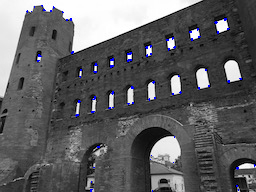

In [3]:
# Read image
img = cv2.imread("thorino.jpg").astype(np.float32)
H, W, C = img.shape

## Grayscale
gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]

# Harris

## Sobel
sobely = np.array(((1, 2, 1),
                   (0, 0, 0),
                   (-1, -2, -1)), dtype=np.float32)

sobelx = np.array(((1, 0, -1),
                   (2, 0, -2),
                   (1, 0, -1)), dtype=np.float32)

tmp = np.pad(gray, (1, 1), 'edge')

Ix = np.zeros_like(gray, dtype=np.float32)
Iy = np.zeros_like(gray, dtype=np.float32)

for y in range(H):
    for x in range(W):
        Ix[y, x] = np.sum(tmp[y:y+3, x:x+3] * sobelx)
        Iy[y, x] = np.sum(tmp[y:y+3, x:x+3] * sobely)

Ix2 = Ix ** 2
Iy2 = Iy ** 2
Ixy = Ix * Iy

## gaussian
K_size = 3
sigma = 3
Ix2_t = np.pad(Ix2, (K_size // 2, K_size // 2), 'edge')
Iy2_t = np.pad(Iy2, (K_size // 2, K_size // 2), 'edge')
Ixy_t = np.pad(Ixy, (K_size // 2, K_size // 2), 'edge')

K = np.zeros((K_size, K_size), dtype=float)
for x in range(K_size):
    for y in range(K_size):
        _x = x - K_size // 2
        _y = y - K_size // 2
        K[y, x] = np.exp( -(_x**2 + _y**2) / (2 * (sigma**2)))
K /= (sigma * np.sqrt(2 * np.pi))
K /= K.sum()

for y in range(H):
    for x in range(W):
        Ix2[y,x] = np.sum(Ix2_t[y:y+K_size, x:x+K_size] * K)
        Iy2[y,x] = np.sum(Iy2_t[y:y+K_size, x:x+K_size] * K)
        Ixy[y,x] = np.sum(Ixy_t[y:y+K_size, x:x+K_size] * K)

out = np.array((gray, gray, gray))
out = np.transpose(out, (1,2,0))

## select corner
k = 0.04
M = (Ix2 * Iy2 - Ixy ** 2) - k * ((Ix2 + Iy2) ** 2)

th = 0.1
out[M >= np.max(M) * th] = [0, 0, 255]

out = out.astype(np.uint8)
display(Image.fromarray(out))

## Q.84. 簡単な画像認識 (Step.1) 減色化 + ヒストグラム

ここでは簡単な画像認識を作成する。

画像認識とは画像に写っているモノが何か（どのクラスに属するか）を特定するタスクである。
画像認識はよく、画像分類、Classification(クラス分類)、Categorization(カテゴライゼーション)、Clustering(クラスタリング)、などと呼ばれる。

よくある手法は画像から何らかの特徴(HOGやSIFT, SURFなど)を抽出し、その特徴によりクラスを判別する。
CNNが流行る以前はこのアプローチがよく取られたが、CNNは特徴抽出から判別までを一括して行える。

ここでは、画像の色ヒストグラムを用いた簡単な画像認識を行う。

アルゴリズムとしては、
1. 画像(train_***.jpg)を減色処理(Q.6. RGBをそれぞれ4階調)する。
2. 減色処理した画像のヒストグラムを作成する。ここでのヒストグラムはRGBがそれぞれ4値をとるが、それらを区別するため、B=[1,4], G=[5,8], R=[9,12]のbin=12となる。それぞれの画像に対応するヒストグラムも保存する必要があるので注意。
 　つまり、database = np.zeros((10(学習データ数), 13(RGB + class), dtype=np.int)　に学習データのヒストグラムを格納する必要がある。
3. ２のヒストグラムをデータベースとする。
4. 認識したい画像(test_@@@.jpg)とヒストグラムの差を計算して、特徴量とする。
5. ヒストグラムの差の合計で、最小となった画像が予測となるクラスである。つまり、色が近い画像と同じクラスになると考えられる。

ここでは1-3を実装し、ヒストグラムを可視化せよ。
学習データはdatasetフォルダにあり train_akahara_@@@.jpg (クラス1)と train_madara_@@@.jpg(クラス2) を用いる。(計10枚)
akaharaとはアカハライモリ、madaraはマダライモリである。


このような予め特徴量を保存しておくデータベース型は人工知能第一世代の手法である。ようは、全部のパターンを暗記しておけばOKという考え方である。ただし、そうするとメモリを大量に消費するので使用が限られる手法である。


|出力(answers/answer_84.png)|
|:---:|
|![](answers/answer_84.png)|

```bash
格納されるヒストグラムの中身
[[  172 12254  2983   975   485 11576  3395   928   387 10090  4845  1062  0]
[ 3627  7350  4420   987  1743  8438  4651  1552   848  9089  4979  1468  0]
[ 1646  6547  5807  2384  1715  8502  5233   934  1553  5270  7167  2394  0]
[  749 10142  5465    28  1431  7922  7001    30  1492  7819  7024    49  0]
[  927  4197  8581  2679   669  5689  7959  2067   506  3973  6387  5518  0]
[ 2821  6404  2540  4619  1625  7317  3019  4423   225  8635  1591  5933  1]
[ 5575  7831  1619  1359  4638  6777  3553  1416  4675  7964  2176  1569  1]
[ 4867  7523  3275   719  4457  6390  3049  2488  4328  7135  3377  1544  1]
[ 7881  6160  1992   351  7426  3967  4258   733  7359  4979  3322   724  1]
[ 5638  6580  3916   250  5041  4185  6286   872  5226  4930  5552   676  1]]
```

[[  172 12254  2983   975   485 11576  3395   928   387 10090  4845  1062
      0]
 [ 3627  7350  4420   987  1743  8438  4651  1552   848  9089  4979  1468
      0]
 [ 1646  6547  5807  2384  1715  8502  5233   934  1553  5270  7167  2394
      0]
 [  749 10142  5465    28  1431  7922  7001    30  1492  7819  7024    49
      0]
 [  927  4197  8581  2679   669  5689  7959  2067   506  3973  6387  5518
      0]
 [ 2821  6404  2540  4619  1625  7317  3019  4423   225  8635  1591  5933
      1]
 [ 5575  7831  1619  1359  4638  6777  3553  1416  4675  7964  2176  1569
      1]
 [ 4867  7523  3275   719  4457  6390  3049  2488  4328  7135  3377  1544
      1]
 [ 7881  6160  1992   351  7426  3967  4258   733  7359  4979  3322   724
      1]
 [ 5638  6580  3916   250  5041  4185  6286   872  5226  4930  5552   676
      1]]


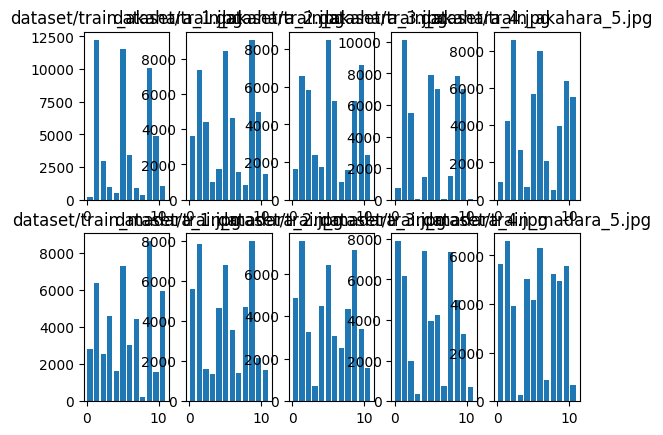

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

## Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

## Database
train = glob("dataset/train_*")
train.sort()

db = np.zeros((len(train), 13), dtype=np.int32)

for i, path in enumerate(train):
    img = dic_color(cv2.imread(path))
    ## histogram
    for j in range(4):
        db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## class
    if 'akahara' in path:
        cls = 0
    elif 'madara' in path:
        cls = 1
    db[i, -1] = cls

    img_h = img.copy() // 64
    img_h[..., 1] += 4
    img_h[..., 2] += 8
    plt.subplot(2, 5, i+1)
    plt.hist(img_h.ravel(), bins=12, rwidth=0.8)
    plt.title(path)

print(db)
plt.show()

## Q.85. 簡単な画像認識 (Step.2) クラス判別

ここではアルゴリズム4-5を実装せよ。

テストデータには test_akahara_@@@.jpgとtest_madara_@@@.jpgを用いよ。（計4枚）
ただし、各画像と最もヒストグラム差分が小さい画像の名前と予測クラスの2つを出力せよ。

これはNearesetNeighbourと呼ばれる評価方法である。

答え

```bash
test_akahara_1.jpg is similar >> train_akahara_3.jpg  Pred >> akahara
test_akahara_2.jpg is similar >> train_akahara_1.jpg  Pred >> akahara
test_madara_1.jpg is similar >> train_madara_2.jpg  Pred >> madara
test_madara_2.jpg is similar >> train_akahara_2.jpg  Pred >> akahara
```

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

## Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

## Database
train = glob("dataset/train_*")
train.sort()

db = np.zeros((len(train), 13), dtype=np.int32)
pdb = []

for i, path in enumerate(train):
    img = dic_color(cv2.imread(path))
    ## histogram
    for j in range(4):
        db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## class
    if 'akahara' in path:
        cls = 0
    elif 'madara' in path:
        cls = 1
    db[i, -1] = cls
    pdb.append(path)

## test
test = glob("dataset/test_*")
test.sort()

success_num = 0.

for path in test:
    img = dic_color(cv2.imread(path))

    hist = np.zeros(12, dtype=np.int32)
    for j in range(4):
        hist[j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        hist[j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        hist[j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## compute difference
    difs = np.abs(db[:, :12] - hist)
    difs = np.sum(difs, axis=1)
    pred_i = np.argmin(difs)
    pred = db[pred_i, -1]

    if pred == 0:
        pl = "akahara"
    elif pred == 1:
        pl = "madara"
    
    print(path, "is similar >>", pdb[pred_i], " Pred >>", pl)

dataset/test_akahara_1.jpg is similar >> dataset/train_akahara_3.jpg  Pred >> akahara
dataset/test_akahara_2.jpg is similar >> dataset/train_akahara_1.jpg  Pred >> akahara
dataset/test_madara_1.jpg is similar >> dataset/train_madara_2.jpg  Pred >> madara
dataset/test_madara_2.jpg is similar >> dataset/train_akahara_2.jpg  Pred >> akahara


## Q.86. 簡単な画像認識 (Step.3) 評価(Accuracy)

ここでは画像認識の結果を評価する。

画像認識の場合はどれくらい正解クラスを予想できたかを示す**Accuracy**(Precisionといったりもする)が一般的な評価指標である。Accuracyは次式で計算される。要はテストにおける得点率である。小数表示するときや、100掛けてパーセンテージで表すこともある。

```bash
Accuracy = (正解した画像数) / (テストした画像の総数)
```
以上を踏まえて、Q.85のAccuracyを求めよ。


答え

```bash
Accuracy >> 0.75 (3/4)
```

In [6]:
## Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

## Database
train = glob("dataset/train_*")
train.sort()

db = np.zeros((len(train), 13), dtype=np.int32)
pdb = []

for i, path in enumerate(train):
    img = dic_color(cv2.imread(path))
    ## histogram
    for j in range(4):
        db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## class
    if 'akahara' in path:
        cls = 0
    elif 'madara' in path:
        cls = 1
    db[i, -1] = cls
    pdb.append(path)

## test
test = glob("dataset/test_*")
test.sort()

success_num = 0.

for path in test:
    img = dic_color(cv2.imread(path))

    hist = np.zeros(12, dtype=np.int32)
    for j in range(4):
        hist[j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        hist[j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        hist[j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## compute difference
    difs = np.abs(db[:, :12] - hist)
    difs = np.sum(difs, axis=1)
    pred_i = np.argmin(difs)
    pred = db[pred_i, -1]

    if pred == 0:
        pl = "akahara"
    elif pred == 1:
        pl = "madara"
    
    print(path, "is similar >>", pdb[pred_i], " Pred >>", pl)

    ## Count success
    gt = "akahara" if "akahara" in path else "madara"
    if gt == pl:
        success_num += 1.

accuracy = success_num / len(test)
print("Accuracy >>", accuracy, "({}/{})".format(int(success_num), len(test)))

dataset/test_akahara_1.jpg is similar >> dataset/train_akahara_3.jpg  Pred >> akahara
dataset/test_akahara_2.jpg is similar >> dataset/train_akahara_1.jpg  Pred >> akahara
dataset/test_madara_1.jpg is similar >> dataset/train_madara_2.jpg  Pred >> madara
dataset/test_madara_2.jpg is similar >> dataset/train_akahara_2.jpg  Pred >> akahara
Accuracy >> 0.75 (3/4)


## Q.87. 簡単な画像認識 (Step.4) k-NN

Q.85では最も色が近い画像が予測クラスであるとしたが、そこで*test_madara_2.jpg*が*train_akahara_2.jpg*と最も色が近いと判断された。

|test_marada_2.jpg|train_akahara_2.jpg|
|:---:|:---:|
|![](dataset/test_madara_2.jpg)|![](dataset/train_akahara_2.jpg)|

2つの画像を見比べるとたしかに両方とも緑の割合と黒の割合が近く見えるので、画像全体に対しての画像の色味が同じ様に見えてしまう。これは認識時のサンプルを一つにしたことによって、例外的な画像が選ばれてしまったためである。このように学習データの特徴は常にきれいに分離されているわけではなく、時に特徴の分布から逸しているサンプルも含まれる。

これを回避するために、ここでは色合いが近い画像を3つ選び、それらの多数決によって予測クラスを決定し、Accuracyを計算せよ。

このように特徴が近いものを学習データからk個選んで判断する手法をk近傍(k-NN: k-Nearest Neighbor)という。Q.85.のNN法はk=1の場合とみれる。


答え
```bash
test_akahara_1.jpg is similar >> train_akahara_3.jpg, train_akahara_2.jpg, train_akahara_4.jpg, |Pred >> akahara
test_akahara_2.jpg is similar >> train_akahara_1.jpg, train_akahara_2.jpg, train_akahara_4.jpg, |Pred >> akahara
test_madara_1.jpg is similar >> train_madara_2.jpg, train_madara_4.jpg, train_madara_3.jpg, |Pred >> madara
test_madara_2.jpg is similar >> train_akahara_2.jpg, train_madara_3.jpg, train_madara_2.jpg, |Pred >> madara
Accuracy >> 1.0 (4/4)
```

In [7]:
## Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

## Database
train = glob("dataset/train_*")
train.sort()

db = np.zeros((len(train), 13), dtype=np.int32)
pdb = []

for i, path in enumerate(train):
    img = dic_color(cv2.imread(path))
    ## histogram
    for j in range(4):
        db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## class
    if 'akahara' in path:
        cls = 0
    elif 'madara' in path:
        cls = 1
    db[i, -1] = cls
    pdb.append(path)

## test
test = glob("dataset/test_*")
test.sort()

success_num = 0.

for path in test:
    img = dic_color(cv2.imread(path))

    hist = np.zeros(12, dtype=np.int32)
    for j in range(4):
        hist[j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        hist[j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        hist[j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## compute difference
    difs = np.abs(db[:, :12] - hist)
    difs = np.sum(difs, axis=1)
    pred_i = np.argsort(difs)[:3]
    pred = db[pred_i, -1]
    if len(pred[pred == 0]) > len(pred[pred == 1]):
        pl = "akahara"
    else:
        pl = 'madara'

    print(path, "is similar >> ", end='')
    for i in pred_i:
        print(pdb[i], end=', ')
    print("|Pred >>", pl)

    ## Count success
    gt = "akahara" if "akahara" in path else "madara"
    if gt == pl:
        success_num += 1.

accuracy = success_num / len(test)
print("Accuracy >>", accuracy, "({}/{})".format(int(success_num), len(test)))

dataset/test_akahara_1.jpg is similar >> dataset/train_akahara_3.jpg, dataset/train_akahara_2.jpg, dataset/train_akahara_4.jpg, |Pred >> akahara
dataset/test_akahara_2.jpg is similar >> dataset/train_akahara_1.jpg, dataset/train_akahara_2.jpg, dataset/train_akahara_4.jpg, |Pred >> akahara
dataset/test_madara_1.jpg is similar >> dataset/train_madara_2.jpg, dataset/train_madara_4.jpg, dataset/train_madara_3.jpg, |Pred >> madara
dataset/test_madara_2.jpg is similar >> dataset/train_akahara_2.jpg, dataset/train_madara_3.jpg, dataset/train_madara_2.jpg, |Pred >> madara
Accuracy >> 1.0 (4/4)


## Q.88. K-means (Step.1) 重心作成

Q.84-87の画像認識は教師データを必要とするいわゆる**教師あり学習**(supervised-training)のものすごく簡単なものだったが、ここでは教師を必要としない**教師なし学習**(unsupervised-training)で画像を分類する。

最も簡単な方法が**K-meansクラスタリング法**である。

これは予めクラス数が分かっている場合に使うことができ、特徴量を重心に分けながらクラスタリングする手法である。

K-Meansアルゴリズムとしては、
1. データにそれぞれランダムにクラスを割り当てる。
2. クラスごとに重心を計算する。
3. 各データと重心の距離を計算し、最も距離が近い重心のクラスを割り当てる。
4. 2-3をクラス変更がなくなるまで繰り返す。

ここでは、減色化とヒストグラムを特徴量として次のようにアルゴリズムを作成する。
1. 画像を減色化し、ヒストグラムを作成し、これを特徴量とする。
2. 各画像にランダムに0か1のクラスを割り当てる。 (ここでは、クラス数=2, np.random.seed(1)　として、np.random.random() < thなら0、>= thなら1を割り当てる。th=0.5)
3. クラスが0、１の特徴量の重心(mean)をそれぞれ取る。(重心は gs = np.zeros((Class, 12), dtype=np.float32)に格納する。)
4. 各画像に対して、特徴量と重心の距離(ユークリッド距離(L1ノルム): 差を二乗し、その合計のsqrtをとったもの)を計算し、距離が近い重心のクラスを割り当てる。
5. 3-4をクラスの変更がなくなるまで繰り返す。

ここでは、1-3までを実装せよ(4,5のことを考えてループを作らなくてもよい)。分類する画像は*test_@@@.jpg*とする。


答え

```bash
assigned label
[[ 1493  7892  4900  2099  1828  9127  4534   895  1554  6750  5406  2674 0]
[  242 10338  3628  2176   587 12212  2247  1338   434 10822  4506   622 1]
[ 6421  5478   719  3766  5482  4294  2537  4071  5609  4823  2051  3901 0]
[ 3343  8134  4756   151  3787  7588  3935  1074  3595  8444  4069   276 0]]
Grabity
[[ 3752.3333  7168.      3458.3333  2005.3334  3699.      7003.
3668.6667  2013.3334  3586.      6672.3335  3842.      2283.6667]
[  242.     10338.      3628.      2176.       587.     12212.
2247.      1338.       434.     10822.      4506.       622.    ]]
```

In [8]:
## Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

## Database
train = glob("dataset/test_*")
train.sort()

db = np.zeros((len(train), 13), dtype=np.int32)
pdb = []

for i, path in enumerate(train):
    img = dic_color(cv2.imread(path))
    ## histogram
    for j in range(4):
        db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## class
    if 'akahara' in path:
        cls = 0
    elif 'madara' in path:
        cls = 1
    db[i, -1] = cls
    pdb.append(path)

# k-Means
Class = 2

feats = db.copy()
np.random.seed(1)
## assign random class 
for i in range(len(feats)):
    if np.random.random() < 0.5:
        feats[i, -1] = 0
    else:
        feats[i, -1] = 1

gs = np.zeros((Class, 12), dtype=np.float32)
    
for i in range(Class):
    gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)
print("assigned label")
print(feats)
print("Grabity")
print(gs)

assigned label
[[ 1493  7892  4900  2099  1828  9127  4534   895  1554  6750  5406  2674
      0]
 [  242 10338  3628  2176   587 12212  2247  1338   434 10822  4506   622
      1]
 [ 6421  5478   719  3766  5482  4294  2537  4071  5609  4823  2051  3901
      0]
 [ 3343  8134  4756   151  3787  7588  3935  1074  3595  8444  4069   276
      0]]
Grabity
[[ 3752.3333  7168.      3458.3333  2005.3334  3699.      7003.
   3668.6667  2013.3334  3586.      6672.3335  3842.      2283.6667]
 [  242.     10338.      3628.      2176.       587.     12212.
   2247.      1338.       434.     10822.      4506.       622.    ]]


## Q.89. K-means (Step.2) クラスタリング

ここではアルゴリズム4-5も実装して、クラスタリングを行え。

ここで予測クラスが0,1となっているが、Q.85-87と違いラベルの順番はバラバラである。
なので、K-meansはあくまでカテゴリ別に分類する手法であり、それが具体的に何のクラスかまでは分からない。
また、クラス数は予めこちらが知って置かなければいけない。

**K-meansクラスタリングでは最初に割り当てるラベルの状態によって、最後の出力が大きく左右される**ので注意が必要である。
また、データ数が少ないと失敗しやすい。これはデータ数が少ないことで、真のデータの分布をサンプリングしにくいことが原因である。つまり、データ数が多いほどデータの分布が精度良くえられることによる。

答え

```bash
test_akahara_1.jpg  Pred: 0
test_akahara_2.jpg  Pred: 1
test_madara_1.jpg  Pred: 0
test_madara_2.jpg  Pred: 0
```

In [9]:
## Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

## Database
train = glob("dataset/test_*")
train.sort()

db = np.zeros((len(train), 13), dtype=np.int32)
pdb = []

for i, path in enumerate(train):
    img = dic_color(cv2.imread(path))
    ## histogram
    for j in range(4):
        db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## class
    if 'akahara' in path:
        cls = 0
    elif 'madara' in path:
        cls = 1
    db[i, -1] = cls
    pdb.append(path)

# k-Means
Class = 2

feats = db.copy()
np.random.seed(1)
## assign random class 
for i in range(len(feats)):
    if np.random.random() < 0.5:
        feats[i, -1] = 0
    else:
        feats[i, -1] = 1

while True:
    gs = np.zeros((Class, 12), dtype=np.float32)
    change_count = 0

    ## compute gravity
    for i in range(Class):
        gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)

    ## re-labeling
    for i in range(len(feats)):
        dis = np.sqrt(np.sum(np.square(np.abs(gs - feats[i, :12])), axis=1))
        pred = np.argmin(dis, axis=0)
        if int(feats[i, -1]) != pred:
            change_count += 1
            feats[i, -1] = pred

    if change_count < 1:
        break

for i in range(len(train)):
    print(pdb[i], " Pred:", feats[i, -1])

dataset/test_akahara_1.jpg  Pred: 0
dataset/test_akahara_2.jpg  Pred: 1
dataset/test_madara_1.jpg  Pred: 0
dataset/test_madara_2.jpg  Pred: 0


## Q.90. K-means (Step.3) 初期ラベルの変更

K-meansを用いて*train_@@@.jpg*の10枚を完璧にクラスタリングせよ。

ここでは、np.random.seed()の値やラベルを割り当てる閾値 np.random.random() < th　のthを変更して、K-meansでクラスを完璧に予測せよ。
*train_@@@.jpg*はQ.89より画像数が２倍以上になっているので、クラスタリングしやすくなっている。

これは試行錯誤するしかない。

答え

```bash
train_akahara_1.jpg  Pred: 1
train_akahara_2.jpg  Pred: 1
train_akahara_3.jpg  Pred: 1
train_akahara_4.jpg  Pred: 1
train_akahara_5.jpg  Pred: 1
train_madara_1.jpg  Pred: 0
train_madara_2.jpg  Pred: 0
train_madara_3.jpg  Pred: 0
train_madara_4.jpg  Pred: 0
train_madara_5.jpg  Pred: 0
```

In [10]:
## Dicrease color
def dic_color(img):
    img //= 63
    img = img * 64 + 32
    return img

## Database
train = glob("dataset/train_*")
train.sort()

db = np.zeros((len(train), 13), dtype=np.int32)
pdb = []

for i, path in enumerate(train):
    img = dic_color(cv2.imread(path))
    ## histogram
    for j in range(4):
        db[i, j] = len(np.where(img[..., 0] == (64 * j + 32))[0])
        db[i, j+4] = len(np.where(img[..., 1] == (64 * j + 32))[0])
        db[i, j+8] = len(np.where(img[..., 2] == (64 * j + 32))[0])

    ## class
    if 'akahara' in path:
        cls = 0
    elif 'madara' in path:
        cls = 1
    db[i, -1] = cls
    pdb.append(path)

# k-Means
Class = 2

feats = db.copy()
np.random.seed(4)
## assign random class 
for i in range(len(feats)):
    if np.random.random() < 0.3:
        feats[i, -1] = 0
    else:
        feats[i, -1] = 1

while True:
    gs = np.zeros((Class, 12), dtype=np.float32)
    change_count = 0

    ## compute gravity
    for i in range(Class):
        gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)

    ## re-labeling
    for i in range(len(feats)):
        dis = np.sqrt(np.sum(np.square(np.abs(gs - feats[i, :12])), axis=1))
        pred = np.argmin(dis, axis=0)
        if int(feats[i, -1]) != pred:
            change_count += 1
            feats[i, -1] = pred

    if change_count < 1:
        break

for i in range(len(train)):
    print(pdb[i], " Pred:", feats[i, -1])

dataset/train_akahara_1.jpg  Pred: 1
dataset/train_akahara_2.jpg  Pred: 1
dataset/train_akahara_3.jpg  Pred: 1
dataset/train_akahara_4.jpg  Pred: 1
dataset/train_akahara_5.jpg  Pred: 1
dataset/train_madara_1.jpg  Pred: 0
dataset/train_madara_2.jpg  Pred: 0
dataset/train_madara_3.jpg  Pred: 0
dataset/train_madara_4.jpg  Pred: 0
dataset/train_madara_5.jpg  Pred: 0
